### AI Bootcamp - June 2024 Cohort - Analyzing and Predicting Flight Delays
Documentation and Context: See the project's ReadMe.md file for documentation on the column names and purposes.

### What's in this workbook?
This is a starter Jupyter Notebook for the project team to use when building out various machine learning models. Each team member will create a copy of this notebook for their work. 

## Libraries Imported
* Pandas
* Numpy
* Matplotlib
* sklearn
    * StandardScaler
    * PCA
    * LabelEncoder

In [372]:
# Do imports
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
# from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC 

### Read In Data to Dataframe

In [373]:
# Create DataFrame
df = pd.read_csv('./data/Airlines.csv')
df.head()

,id,Airline,Flight,AirportFrom,AirportTo,DayOfWeek,Time,Length,Delay
0,1,CO,269,SFO,IAH,3,15,205,1
1,2,US,1558,PHX,CLT,3,15,222,1
2,3,AA,2400,LAX,DFW,3,20,165,1
3,4,AA,2466,SFO,DFW,3,20,195,1
4,5,AS,108,ANC,SEA,3,30,202,0


In [374]:
df.describe()

,id,Flight,DayOfWeek,Time,Length,Delay
count,539383.00000,539383.000000,539383.000000,539383.000000,539383.000000,539383.000000
mean,269692.00000,2427.928630,3.929668,802.728963,132.202007,0.445442
std,155706.60446,2067.429837,1.914664,278.045911,70.117016,0.497015
min,1.00000,1.000000,1.000000,10.000000,0.000000,0.000000
25%,134846.50000,712.000000,2.000000,565.000000,81.000000,0.000000
50%,269692.00000,1809.000000,4.000000,795.000000,115.000000,0.000000
75%,404537.50000,3745.000000,5.000000,1035.000000,162.000000,1.000000
max,539383.00000,7814.000000,7.000000,1439.000000,655.000000,1.000000


In [375]:
len(df['AirportFrom'].unique())

293

In [376]:
df['Time_encoded'] = df['Time'].apply(lambda x: f"{x // 60:02d}:{x % 60:02d}")
df.head()

,id,Airline,Flight,AirportFrom,AirportTo,DayOfWeek,Time,Length,Delay,Time_encoded
0,1,CO,269,SFO,IAH,3,15,205,1,00:15
1,2,US,1558,PHX,CLT,3,15,222,1,00:15
2,3,AA,2400,LAX,DFW,3,20,165,1,00:20
3,4,AA,2466,SFO,DFW,3,20,195,1,00:20
4,5,AS,108,ANC,SEA,3,30,202,0,00:30


In [377]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 539383 entries, 0 to 539382
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            539383 non-null  int64 
 1   Airline       539383 non-null  object
 2   Flight        539383 non-null  int64 
 3   AirportFrom   539383 non-null  object
 4   AirportTo     539383 non-null  object
 5   DayOfWeek     539383 non-null  int64 
 6   Time          539383 non-null  int64 
 7   Length        539383 non-null  int64 
 8   Delay         539383 non-null  int64 
 9   Time_encoded  539383 non-null  object
dtypes: int64(6), object(4)
memory usage: 41.2+ MB


### Preprocessing : Encoding 'AirportFrom', 'AirportTo', 'Airline' Columns

In [378]:
airport_codes = df['AirportFrom'].unique()
airport_codes

array(['SFO', 'PHX', 'LAX', 'ANC', 'LAS', 'SLC', 'DEN', 'ONT', 'FAI',
       'BQN', 'PSE', 'HNL', 'BIS', 'IYK', 'EWR', 'BOS', 'MKE', 'GFK',
       'OMA', 'GSO', 'LMT', 'SEA', 'MCO', 'TPA', 'DLH', 'MSP', 'FAR',
       'MFE', 'MSY', 'VPS', 'BWI', 'MAF', 'LWS', 'RST', 'ALB', 'DSM',
       'CHS', 'MSN', 'JAX', 'SAT', 'PNS', 'BHM', 'LIT', 'SAV', 'BNA',
       'ICT', 'ECP', 'DHN', 'MGM', 'CAE', 'PWM', 'ACV', 'EKO', 'PHL',
       'ATL', 'PDX', 'RIC', 'BTR', 'HRL', 'MYR', 'TUS', 'SBN', 'CAK',
       'TVC', 'CLE', 'ORD', 'DAY', 'MFR', 'BTV', 'TLH', 'TYS', 'DFW',
       'FLL', 'AUS', 'CHA', 'CMH', 'LRD', 'BRO', 'CRP', 'LAN', 'PVD',
       'FWA', 'JFK', 'LGA', 'OKC', 'PIT', 'PBI', 'ORF', 'DCA', 'AEX',
       'SYR', 'SHV', 'VLD', 'BDL', 'FAT', 'BZN', 'RDM', 'LFT', 'IPL',
       'EAU', 'ERI', 'BUF', 'IAH', 'MCI', 'AGS', 'ABI', 'GRR', 'LBB',
       'CLT', 'LEX', 'MBS', 'MOD', 'AMA', 'SGF', 'AZO', 'ABE', 'SWF',
       'BGM', 'AVP', 'FNT', 'GSP', 'ATW', 'ITH', 'TUL', 'COS', 'ELP',
       'ABQ', 'SMF',

### Make a copy of Dataframe for preprocessing

In [379]:
encoded_df = df.copy()

In [380]:
unique_codes = encoded_df['AirportFrom'].unique()
code_to_id = {code: idx for idx, code in enumerate(unique_codes, start=1)}

# Apply the mapping to create a new column with unique IDs
encoded_df['AirportFroIDs'] = encoded_df['AirportFrom'].map(code_to_id)
encoded_df['AirportToIDs'] = encoded_df['AirportTo'].map(code_to_id)

encoded_df

,id,Airline,Flight,AirportFrom,AirportTo,DayOfWeek,Time,Length,Delay,Time_encoded,AirportFroIDs,AirportToIDs
0,1,CO,269,SFO,IAH,3,15,205,1,00:15,1,103
1,2,US,1558,PHX,CLT,3,15,222,1,00:15,2,109
2,3,AA,2400,LAX,DFW,3,20,165,1,00:20,3,72
3,4,AA,2466,SFO,DFW,3,20,195,1,00:20,1,72
4,5,AS,108,ANC,SEA,3,30,202,0,00:30,4,22
...,...,...,...,...,...,...,...,...,...,...,...,...
539378,539379,CO,178,OGG,SNA,5,1439,326,0,23:59,194,229
539379,539380,FL,398,SEA,ATL,5,1439,305,0,23:59,22,55
539380,539381,FL,609,SFO,MKE,5,1439,255,0,23:59,1,17
539381,539382,UA,78,HNL,SFO,5,1439,313,1,23:59,12,1


In [381]:
# Get unique airline codes
unique_airlines = encoded_df['Airline'].unique()

# Create a random mapping for each unique airline code
random.seed(1)  # Set a seed for reproducibility, remove if you want different random results each time
airline_to_id = {airline: random.randint(1000, 9999) for airline in unique_airlines}

# Apply the random mapping to the airline column
encoded_df['airline_id'] = encoded_df['Airline'].map(airline_to_id)

encoded_df.head()

,id,Airline,Flight,AirportFrom,AirportTo,DayOfWeek,Time,Length,Delay,Time_encoded,AirportFroIDs,AirportToIDs,airline_id
0,1,CO,269,SFO,IAH,3,15,205,1,00:15,1,103,3201
1,2,US,1558,PHX,CLT,3,15,222,1,00:15,2,109,2033
2,3,AA,2400,LAX,DFW,3,20,165,1,00:20,3,72,5179
3,4,AA,2466,SFO,DFW,3,20,195,1,00:20,1,72,5179
4,5,AS,108,ANC,SEA,3,30,202,0,00:30,4,22,2931


In [382]:
len(encoded_df["AirportFrom"].unique())

293

In [383]:
len(encoded_df["AirportTo"].unique())

293

In [384]:
# Drop all the categorical columns
encoded_df = encoded_df.drop(columns=['Airline', 'AirportFrom', 'AirportTo'])
encoded_df.head()

,id,Flight,DayOfWeek,Time,Length,Delay,Time_encoded,AirportFroIDs,AirportToIDs,airline_id
0,1,269,3,15,205,1,00:15,1,103,3201
1,2,1558,3,15,222,1,00:15,2,109,2033
2,3,2400,3,20,165,1,00:20,3,72,5179
3,4,2466,3,20,195,1,00:20,1,72,5179
4,5,108,3,30,202,0,00:30,4,22,2931


In [385]:
# Drop unused columns

encoded_df = encoded_df.copy()
encoded_df.drop(['id', 'Time_encoded'], axis=1, inplace=True)


In [386]:
X = encoded_df.copy()
X.drop('Delay', axis=1, inplace=True)
X.head()

,Flight,DayOfWeek,Time,Length,AirportFroIDs,AirportToIDs,airline_id
0,269,3,15,205,1,103,3201
1,1558,3,15,222,2,109,2033
2,2400,3,20,165,3,72,5179
3,2466,3,20,195,1,72,5179
4,108,3,30,202,4,22,2931


In [387]:
y = df['Delay']

In [388]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

### Scale the Data
SVM, KNN, K-Means, and PCA need scaling

In [389]:
# Scaling the X data by using StandardScaler()
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_train_scaled

array([[-1.09447296,  1.08199271,  0.01063145, ...,  1.82992654,
        -1.05211002,  1.19989696],
       [ 2.01121043, -1.00719177,  1.00286384, ...,  2.43184152,
        -0.19638348,  0.63696251],
       [-0.8346985 ,  0.55969659, -0.35246809, ..., -1.21132809,
        -0.38654493, -1.28621145],
       ...,
       [ 0.14828415, -1.00719177, -1.26920454, ...,  0.8636946 ,
        -0.83025499,  1.340816  ],
       [ 1.46021769, -0.48489565, -0.83779915, ..., -0.37181509,
        -0.76686784,  1.29483189],
       [ 0.77038833, -0.48489565, -0.22664152, ...,  0.89537434,
        -0.19638348, -1.65668017]])

In [390]:
X_test_scaled = scaler.transform(X_test)
X_test_scaled

array([[-1.13268931,  0.03740047, -0.99957617, ..., -1.21132809,
        -0.35485136, -1.28621145],
       [-0.45737249, -0.48489565, -1.44895678, ...,  0.3726587 ,
        -0.87779535, -0.27938204],
       [ 0.77232333,  0.55969659,  0.52831791, ...,  0.10338094,
        -0.37069815, -0.39397147],
       ...,
       [ 1.25752589, -1.52948788, -1.59275858, ...,  1.03793315,
        -0.37069815,  1.29483189],
       [ 0.59527036,  1.60428882,  1.08554987, ..., -1.21132809,
         0.94458524, -0.27938204],
       [-0.66054803,  0.55969659, -0.04688927, ..., -0.0708576 ,
         0.07301191,  1.06157381]])

### SVM

In [391]:
# Create the support vector machine classifier model
svc_model = SVC(kernel='linear', max_iter=10000)

In [392]:
svc_model.fit(X_train_scaled, y_train)

/opt/anaconda3/envs/dev/lib/python3.10/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


SVC(kernel='linear', max_iter=10000)

In [393]:
# Validate the model by checking the model accuracy with model.score
svc_train_score = svc_model.score(X_train_scaled, y_train) 
print(f'The SVC training score is: {svc_train_score}')
svc_test_score = svc_model.score(X_test_scaled, y_test)
print(f'The SVC testing score is: {svc_test_score}') 

The SVC training score is: 0.4469875437846229
The SVC testing score is: 0.4474659982498554


### Random Forest

In [394]:
# Create and train a randomforest model
random_model = RandomForestClassifier(n_estimators=500, max_depth=5)
random_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, n_estimators=500)

In [395]:
# Check the model's balanced accuracy on the TEST set
y_test_pred = random_model.predict(X_test)
ran_test_bal_score = balanced_accuracy_score(y_test, y_test_pred) 
print(ran_test_bal_score)
# print(balanced_accuracy_score(y_test, y_test_pred))

0.6039854461754521


In [396]:
# Check the model's balanced accuracy on the training set
y_train_pred = random_model.predict(X_train)
ran_train_bal_score = balanced_accuracy_score(y_train, y_train_pred)
print(ran_train_bal_score)
# print(balanced_accuracy_score(y_train, y_train_pred))

0.6032590332996771


### Logistic Regression

In [397]:
# Create a LogisticRegression function
logistic_regression_model = LogisticRegression(max_iter=1000)

In [398]:
# Fit the model for Logistic Regression
logistic_regression_model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [399]:
# Score the model
print(f'The training data score: {logistic_regression_model.score(X_train, y_train)}')
print(f'The testing data score: {logistic_regression_model.score(X_test, y_test)}')
      

The training data score: 0.5696190954103085
The testing data score: 0.5709031042819216


In [400]:
# Generate predictions from the model we just fit
log_predictions = logistic_regression_model.predict(X_train)

# Convert those predictions (and actual values) to a DataFrame
log_results_df = pd.DataFrame({'Prediction': log_predictions, 'Actual': y_train})

In [401]:
# Apply the fitted model to the test dataset
log_testing_predictions = logistic_regression_model.predict(X_test)

# Save both the test predictions and actual test values to a DataFrame
log_results_df = pd.DataFrame({
    "Testing Data Predictions": log_testing_predictions, 
    "Testing Data Actual Targets": y_test})

In [402]:
# Display the results DataFrame
log_results_df.head()

,Testing Data Predictions,Testing Data Actual Targets
21403,0,0
121631,0,1
535153,0,1
415037,0,0
69899,0,0


In [403]:
# Import the accuracy score function
from sklearn.metrics import accuracy_score

# Calculate the model's accuracy on the test dataset
log_accuracy_score = accuracy_score(y_test, log_testing_predictions)
log_accuracy_score

0.5709031042819216

### Summary for All Models

In [404]:
print("SVC")
print(f'SVC testing accuracy score: {svc_test_score}')
print(f'SVC training accuracy score: {svc_train_score}')
print("*" * 20)
print("RANDOM FOREST")
print(f'Random Forest test accuracy score: {ran_test_bal_score}')
print(f'Random Forest training accuracy score: {ran_train_bal_score}')
print("*" * 20)
print("LOGISTIC REGRESSION")
print(f'LogisticRegression accuracy score: {log_accuracy_score}')

SVC
SVC testing accuracy score: 0.4474659982498554
SVC training accuracy score: 0.4469875437846229
********************
RANDOM FOREST
Random Forest test accuracy score: 0.6039854461754521
Random Forest training accuracy score: 0.6032590332996771
********************
LOGISTIC REGRESSION
LogisticRegression accuracy score: 0.5709031042819216


## KMeans 
---
# Original Dataset
 1. Explore the Original Data
    *  Use the elbow method to determine the optimal number for k
    * Plot the graph and print the % change for k value
    * Determine the best number of k
2. Use the optimal number recommended from Elbow Method to instantiate the KMeans model
    - Create and fit KMeans model where n_cluster = optimal elbow k value
    - Make predictions
    - Plot & Visualize data predictions

# Scaled Dataset
1. Split and Scale the data 
    - Using `test_train_split`, split the data. 
    - Scale the data separately 'X_train', 'X-test' using StandardScaler()
2. Use Elbow Method To Determine The Best Value For k
    - Loop through inertia and create a dataframe with k-values
    - Plot the Elbow Curve
    - Print the percent change between k values
3. Use the optimal number for k to create scaled_kmeans_model

# Random Undersampling
1. Split the data using `test_train_split`
2. Instantiate and perform undersampling on training data
3. Instantiate KMeans model and fit the resampled data
4. Make predictions and plot using original data

# Scoring Models
1. Import calinski_harabasz_score
2. Score each model using calinski_harabasz_score
3. Print the calinski_harabasz_score for each method
    * Original Dataset Predictions
    * Scaled Dataset Predictions
    * Random Undersampling Predictions


# Original Dataset
## 1. Explore The Original Data

In [405]:
# Make A Copy Of 'encoded_df' Dataframe
k_df = encoded_df.copy()

# Set up X and y variables
X = k_df.copy()
X = X.drop(columns='Delay')

# Set up y variable
y = k_df['Delay']
X.head()

,Flight,DayOfWeek,Time,Length,AirportFroIDs,AirportToIDs,airline_id
0,269,3,15,205,1,103,3201
1,1558,3,15,222,2,109,2033
2,2400,3,20,165,3,72,5179
3,2466,3,20,195,1,72,5179
4,108,3,30,202,4,22,2931


In [406]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

### **Original Data**: Elbow method to determine the optimal number for k

In [407]:
# Create an empty list to store the inertia values
inertia = []

# Create a list with the number of k-values to try
k = list(range(1, 11))

# Create a for-loop where each value of k is evaluated using the K-means algorithm
# Fit the model using the service_ratings DataFrame
# Append the value of the computed inertia from the `inertia_` attribute of the KMeans model instance
for i in k:
    k_model = KMeans(n_clusters=i, n_init='auto', random_state=0)
    k_model.fit(X_train)
    inertia.append(k_model.inertia_)

# Define a DataFrame to hold the values for k and the corresponding inertia
elbow_data = {"k": k, "inertia": inertia}
df_elbow = pd.DataFrame(elbow_data)

# Review the DataFrame
df_elbow

,k,inertia
0,1,5.022175e+12
1,2,2.508895e+12
2,3,1.546859e+12
3,4,8.839597e+11
4,5,6.645512e+11
5,6,5.141754e+11
6,7,4.001263e+11
7,8,3.752420e+11
8,9,3.235171e+11
9,10,2.741019e+11


### **Original Data**: Plot the graph for elbow curve

<Axes: title={'center': 'Elbow Curve'}, xlabel='k'>

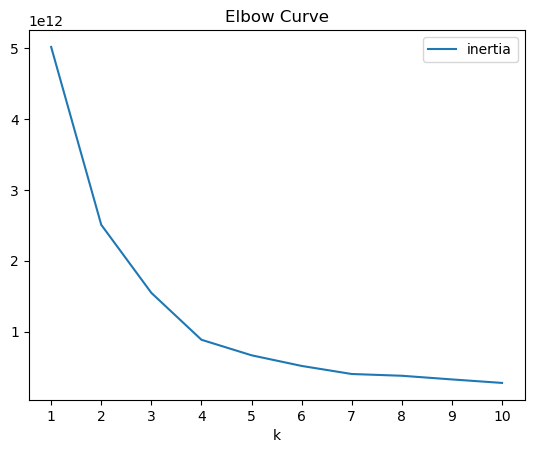

In [408]:
# Plot the Elbow curve
df_elbow.plot.line(x="k",
                   y="inertia",
                   title="Elbow Curve",
                   xticks=k)

### **Original Data**: Print the percent change between each k-value

In [409]:
# Determine the rate of decrease between each k value. 
k = elbow_data["k"]
inertia = elbow_data["inertia"]
for i in range(1, len(k)):
    percentage_decrease = (inertia[i-1] - inertia[i]) / inertia[i-1] * 100
    print(f"Percentage decrease from k={k[i-1]} to k={k[i]}: {percentage_decrease:.2f}%")

Percentage decrease from k=1 to k=2: 50.04%
Percentage decrease from k=2 to k=3: 38.35%
Percentage decrease from k=3 to k=4: 42.85%
Percentage decrease from k=4 to k=5: 24.82%
Percentage decrease from k=5 to k=6: 22.63%
Percentage decrease from k=6 to k=7: 22.18%
Percentage decrease from k=7 to k=8: 6.22%
Percentage decrease from k=8 to k=9: 13.78%
Percentage decrease from k=9 to k=10: 15.27%


## Elbow Results
### **The best value for k is 5**
---

## 2. Use The Recommendeded K-value To Instantiate The KMeans Model

### Create and fit KMeans model with optimal k value and make predictions


In [435]:
# Define the model with 6 clusters
model = KMeans(n_clusters=5, n_init='auto', random_state=1)

# Fit the model
model.fit(X_train)

# Make predictions
original_train_labels = model.predict(X_train)
original_test_labels = model.predict(X_test)


# Cluster Labels
original_labels = model.labels_

# Scaled Dataset

### 1. Split and Scale The Data

### Using `test_train_split`, split the data. 

In [437]:
# Set up X and y variables
X = encoded_df.copy()
X = X.drop(columns='Delay')

y = encoded_df['Delay']

In [438]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [439]:
# Create instance of StandardScaler
scaler = StandardScaler()

# Scale the X training and test data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### 2. Use Elbow Method To Determine The Best Value For k

### **Scaled Data**: Loop through inertia and create a dataframe with k-values

In [440]:
# Create a a list to store inertia values and the values of k
inertia = []
k = list(range(1, 11))

# Create a for loop to compute the inertia with each possible value of k and add the values to the inertia list.
for i in k:
    model = KMeans(n_clusters=i, n_init='auto', random_state=1)
    model.fit(X_train_scaled)
    inertia.append(model.inertia_)

# Create a dictionary with the data to plot the elbow curve
elbow_data = {
    "k": k,
    "inertia": inertia
}

# Create a DataFrame with the data to plot the elbow curve
df_elbow = pd.DataFrame(elbow_data)

# Display the DataFrame
df_elbow

,k,inertia
0,1,2.831759e+06
1,2,2.444747e+06
2,3,2.216848e+06
3,4,2.019530e+06
4,5,1.869659e+06
5,6,1.735246e+06
6,7,1.639387e+06
7,8,1.560811e+06
8,9,1.503254e+06
9,10,1.439195e+06


### **Scaled Data**: Plot the Elbow Curve

<Axes: title={'center': 'Elbow Curve'}, xlabel='k'>

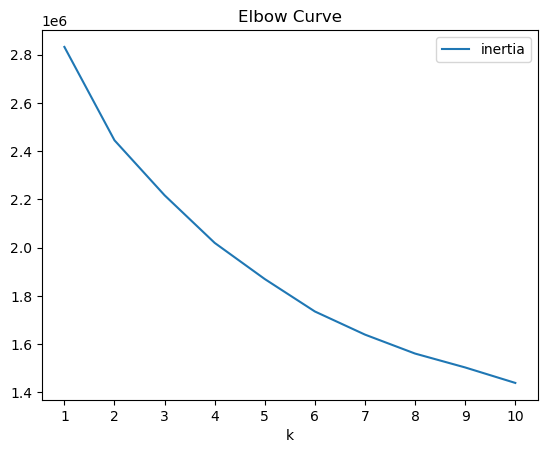

In [441]:
# Plot the Elbow curve
df_elbow.plot.line(x="k",
                   y="inertia",
                   title="Elbow Curve",
                   xticks=k)

### **Scaled Data**: Print the percent change between k-values

In [442]:
# Determine the rate of decrease between each k value. 
k = elbow_data["k"]
inertia = elbow_data["inertia"]
for i in range(1, len(k)):
    percentage_decrease = (inertia[i-1] - inertia[i]) / inertia[i-1] * 100
    print(f"Percentage decrease from k={k[i-1]} to k={k[i]}: {percentage_decrease:.2f}%")

Percentage decrease from k=1 to k=2: 13.67%
Percentage decrease from k=2 to k=3: 9.32%
Percentage decrease from k=3 to k=4: 8.90%
Percentage decrease from k=4 to k=5: 7.42%
Percentage decrease from k=5 to k=6: 7.19%
Percentage decrease from k=6 to k=7: 5.52%
Percentage decrease from k=7 to k=8: 4.79%
Percentage decrease from k=8 to k=9: 3.69%
Percentage decrease from k=9 to k=10: 4.26%


### Elbow curve suggest that the optimal number for k is 3
The rate of decrease in inertia **begins** to slow down between k=3 and k=4, which means that our elbow point is at k=3.

### 3. Use the optimal number for k to create scaled_kmeans_model

In [443]:
# Define the model with 3 clusters
model = KMeans(n_clusters=3, n_init='auto', random_state=1)

# Fit the model
model.fit(X_train_scaled)

# Make predictions
kmeans_train_scaled_labels = model.predict(X_train_scaled)
kmeans_test_scaled_labels = model.predict(X_test_scaled)

# Create labels 
scaled_labels = model.labels_

## Random Undersampling
---
1. Split the data using `test_train_split`
2. Instantiate and perform undersampling on training data
3. Instantiate KMeans model and fit the resampled data
4. Make predictions and plot using original data

### 1. Split the data using `test_train_split`

In [444]:
# Set up X and y variables
X = encoded_df.copy()
X = X.drop(columns='Delay')

# Set up y variable
y = encoded_df['Delay']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

### 2. Instantiate and fit the RandomUnderSampler, random_state = 1 (universal across project)

In [445]:
from imblearn.under_sampling import RandomUnderSampler

# Initialize RandomUnderSampler to handle class imbalance
rus = RandomUnderSampler(random_state=1)

# Perform undersampling on the training data
X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)

### 3. Instantiate KMeans model and fit the resampled data

In [446]:
# Fit KMeans on the undersampled data
kmeans = KMeans(n_clusters=3, random_state=1)
kmeans.fit(X_train_resampled)

KMeans(n_clusters=3, random_state=1)

### 4. Make predictions and plot using original data

In [447]:
# Predict clusters for the training and test data
ru_train_labels = kmeans.predict(X_train_resampled)
ru_test_labels = kmeans.predict(X_test)

# Create labels 
ru_labels = kmeans.labels_

## Score The KMeans Model
1. Import calinski_harabasz_score
2. Score each model using calinski_harabasz_score
3. Print the calinski_harabasz_score for each method
    * Original Dataset Predictions
    * Scaled Dataset Predictions
    * Random Undersampling Predictions

### 1. Import calinski_harabasz_score

In [448]:
from sklearn.metrics import calinski_harabasz_score

### 2. Score each model using calinski_harabasz_score

In [451]:
# Calculate the Calinski-Harabasz score on the Original training and test data
original_train_score = calinski_harabasz_score(X_train, original_train_labels)
original_test_score = calinski_harabasz_score(X_test, original_test_labels)

# Calculate the Calinski-Harabasz score on the Scaled training and test data
train_scaled_ch_score = calinski_harabasz_score(X_train_scaled, kmeans_train_scaled_labels)
test_scaled_ch_score = calinski_harabasz_score(X_test_scaled, kmeans_test_scaled_labels)

# Calculate the Calinski-Harabasz score on the Random Undersampled training and test data
train_resampled_ch_score = calinski_harabasz_score(X_train_resampled, ru_train_labels)
test_resampled_ch_score = calinski_harabasz_score(X_test, ru_test_labels)

### 3. Print the Calinski-Harabasz Score for each method

In [455]:
# Print the score for the original training and testing data
print("Original Score")
print(f"Calinski-Harabasz Score on Original Training Data: {original_train_score:.2f}")
print(f"Calinski-Harabasz Score on Original Testing Data: {original_test_score:.2f}\n")

# Print the score for the Scaled data
print("Scaled Score")
print(f"Calinski-Harabasz Score on the Scaled Training Data: {train_scaled_ch_score:.2f}")
print(f"Calinski-Harabasz Score on the Scaled Test Data: {test_scaled_ch_score:.2f}\n")

# Print the score for the Random Undersampled data
print("Undersampled Score")
print(f"Calinski-Harabasz Score on the Undersampled Training Data: {train_resampled_ch_score:.2f}")
print(f"Calinski-Harabasz Score on the Undersampled Test Data: {test_resampled_ch_score:.2f}\n")

Original Score
Calinski-Harabasz Score on Original Training Data: 663289.95
Calinski-Harabasz Score on Original Testing Data: 220753.49

Scaled Score
Calinski-Harabasz Score on the Scaled Training Data: 56106.58
Calinski-Harabasz Score on the Scaled Test Data: 18715.40

Undersampled Score
Calinski-Harabasz Score on the Undersampled Training Data: 308578.14
Calinski-Harabasz Score on the Undersampled Test Data: 116584.11



# Model Optimization
1. Feature Engineering
* `AirportTo | AirportFro Columns` When building the model we decided on encoding the airports in each column together to give the model more context, which may have affected the overall outcome. In this model, the encoding will be random for each column to allow the model to work naturally against the data. 
2. MinMax Scaler
* To optimize the model we are going to test MinMaxScaler against the StandardScaler()
3. Silhoutte Scoring & Calinski-Harabasz Score
* Score the data using Silhouette scoring with 10% of random selection of the data to avoid memory problem
---

## Feature Engineering
1. Encode all categorical columns with no connection
- Use OrdinalEncoder to encode the `Airline` column and reshape
- Use OrdinalEncoder to encode the `AirportFro` column and reshape
-  Use OrdinalEncoder to encode the `AirportTo` column and reshape
### Use OneHotEncoder | OrdinalEncoder to encode categorical data -- separating airport ID's

### 1. Encode all categorical columns with no connection

In [63]:
# Import OneHotEncoder and OrdinalEncoder
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder

### Use OrdinalEncoder to encode the `Airline` column and reshape

In [64]:
# This is ordinal! Lets use the ordinal encoder
# We'll set any unknown values to -1
encode_airline = OrdinalEncoder(categories=[['XE', 'CO', 'MQ', 'US', 'OH', 'UA', 'WN', 'DL', 'AA', 'AS', 'OO',
       '9E', 'EV', 'FL', 'HA', 'B6', 'YV', 'F9']], handle_unknown='use_encoded_value', unknown_value=-1)

# Train the encoder
encode_airline.fit(X_train['Airline'].values.reshape(-1, 1))

OrdinalEncoder(categories=[['XE', 'CO', 'MQ', 'US', 'OH', 'UA', 'WN', 'DL',
                            'AA', 'AS', 'OO', '9E', 'EV', 'FL', 'HA', 'B6',
                            'YV', 'F9']],
               handle_unknown='use_encoded_value', unknown_value=-1)

### Use OrdinalEncoder to encode the `AirportFro` column and reshape

In [65]:
encode_airport_from = OrdinalEncoder(categories=[['IAH', 'MSP', 'OMA', 'IND', 'ORD', 'PIT', 'DTW', 'BNA', 'LGA',
       'TUS', 'KTN', 'SEA', 'DFW', 'ATL', 'MEM', 'SFO', 'DCA', 'DAY',
       'RDU', 'CLT', 'LAX', 'PHX', 'MCI', 'PDX', 'ISP', 'JAX', 'BUR',
       'JAN', 'TYS', 'EWR', 'PBI', 'DEN', 'SAT', 'BOS', 'EYW', 'SJC',
       'HNL', 'FSD', 'SMF', 'GEG', 'DAL', 'MDW', 'HRL', 'LGB', 'TPA',
       'ABQ', 'SGF', 'CAE', 'AUS', 'SAN', 'SJU', 'ONT', 'MSY', 'SLC',
       'BWI', 'MCO', 'LAS', 'ORF', 'JFK', 'MSO', 'DSM', 'SNA', 'VPS',
       'PSP', 'BDL', 'IAD', 'OKC', 'AEX', 'LIH', 'ATW', 'BHM', 'DAB',
       'TUL', 'PHF', 'BMI', 'CAK', 'COS', 'FLL', 'CLE', 'RNO', 'LIT',
       'OGG', 'MIA', 'ELP', 'ALB', 'CRP', 'PHL', 'ICT', 'OAK', 'ANC',
       'MKE', 'MYR', 'SGU', 'ROC', 'FCA', 'CRW', 'RSW', 'STL', 'CMH',
       'LWS', 'BUF', 'RIC', 'CMI', 'ACY', 'HOU', 'ECP', 'SBP', 'KOA',
       'PVD', 'MLI', 'MHT', 'CID', 'FWA', 'MLU', 'FAT', 'RAP', 'BTR',
       'LNK', 'GSO', 'MOD', 'BTV', 'CHS', 'RDM', 'SYR', 'PNS', 'CVG',
       'MOB', 'GJT', 'AVL', 'TLH', 'XNA', 'COD', 'FNT', 'PIH', 'SDF',
       'SPS', 'LFT', 'BOI', 'GRB', 'MRY', 'GRR', 'EVV', 'SMX', 'AZO',
       'ITO', 'FAR', 'GSP', 'ACV', 'MBS', 'AGS', 'SBA', 'BZN', 'PWM',
       'DRO', 'HPN', 'LBB', 'FAY', 'TVC', 'ABE', 'PIA', 'SRQ', 'OAJ',
       'ROA', 'SHV', 'SBN', 'HDN', 'MGM', 'HSV', 'DLH', 'TOL', 'PSG',
       'SUN', 'CWA', 'TWF', 'AMA', 'ABI', 'AVP', 'MSN', 'JNU', 'MFR',
       'MTJ', 'ADQ', 'BFL', 'PSE', 'CSG', 'GTR', 'ASE', 'LCH', 'LRD',
       'LMT', 'HTS', 'MDT', 'MFE', 'CIC', 'WRG', 'LEX', 'CHA', 'LAN',
       'BIS', 'MAF', 'GTF', 'EKO', 'CEC', 'IDA', 'MEI', 'MHK', 'ITH',
       'BIL', 'IYK', 'MOT', 'COU', 'GRK', 'GUC', 'RDD', 'CDV', 'DHN',
       'BET', 'HLN', 'PSC', 'SAV', 'ERI', 'ILM', 'TRI', 'FLG', 'EGE',
       'LSE', 'OTZ', 'CPR', 'YUM', 'CMX', 'PIE', 'TXK', 'EAU', 'FSM',
       'SCC', 'SCE', 'EUG', 'ELM', 'JAC', 'FAI', 'OME', 'LWB', 'VLD',
       'GPT', 'EWN', 'GGG', 'CLD', 'MKG', 'SWF', 'RKS', 'MLB', 'GNV',
       'ROW', 'BRO', 'TYR', 'ABY', 'LYH', 'CHO', 'BTM', 'BKG', 'MMH',
       'RST', 'GFK', 'PAH', 'SPI', 'STX', 'GCC', 'SAF', 'TEX', 'STT',
       'PLN', 'BQN', 'BRW', 'IPL', 'UTM', 'MQT', 'CLL', 'CYS', 'ACT',
       'BLI', 'OTH', 'SIT', 'YAK', 'BGM', 'CDC', 'BQK', 'DBQ', 'FLO',
       'BGR', 'SJT', 'ADK', 'GUM', 'ABR']])

# Train the encoder
encode_airport_from.fit(X_train['AirportFrom'].values.reshape(-1, 1))

OrdinalEncoder(categories=[['IAH', 'MSP', 'OMA', 'IND', 'ORD', 'PIT', 'DTW',
                            'BNA', 'LGA', 'TUS', 'KTN', 'SEA', 'DFW', 'ATL',
                            'MEM', 'SFO', 'DCA', 'DAY', 'RDU', 'CLT', 'LAX',
                            'PHX', 'MCI', 'PDX', 'ISP', 'JAX', 'BUR', 'JAN',
                            'TYS', 'EWR', ...]])

### Use OrdinalEncoder to encode the `AirportTo` column and reshape

In [66]:
encode_airport_to = OrdinalEncoder(categories=[['MCI', 'DEN', 'LGA', 'EWR', 'CLT', 'DTW', 'GRR', 'PHL', 'MIA',
       'ATL', 'ORD', 'WRG', 'SMF', 'IND', 'SBP', 'TRI', 'CHS', 'CVG',
       'MSP', 'MCO', 'MDW', 'AUS', 'SAN', 'BHM', 'SLC', 'SFO', 'DCA',
       'MEM', 'FAT', 'LAS', 'ABI', 'BWI', 'OAK', 'DFW', 'HNL', 'CAK',
       'SNA', 'OGG', 'BUR', 'PDX', 'DAL', 'ICT', 'BDL', 'IAH', 'SDF',
       'HOU', 'GRB', 'JFK', 'BIL', 'ONT', 'MSO', 'RDU', 'OMA', 'IAD',
       'PHX', 'LAX', 'SEA', 'TUL', 'ATW', 'OKC', 'SAT', 'ALB', 'MKE',
       'BNA', 'XNA', 'FLL', 'ISP', 'MHK', 'BQK', 'BOS', 'CAE', 'CMH',
       'LIT', 'ITO', 'STL', 'SJU', 'PIT', 'BIS', 'ABQ', 'PHF', 'LEX',
       'GEG', 'ELP', 'MAF', 'SJC', 'MSY', 'TPA', 'FCA', 'FAY', 'GPT',
       'MLB', 'DSM', 'OTH', 'RNO', 'ACV', 'MFE', 'MHT', 'GJT', 'TUS',
       'PBI', 'HRL', 'MKG', 'FAR', 'JAX', 'LGB', 'MBS', 'RDM', 'SBN',
       'TYS', 'MRY', 'RSW', 'ROC', 'HDN', 'CLE', 'MSN', 'GSP', 'PVD',
       'FSM', 'FAI', 'COS', 'VPS', 'BQN', 'STT', 'LSE', 'EUG', 'TLH',
       'ROA', 'PWM', 'CRW', 'SBA', 'HLN', 'BUF', 'PIA', 'BOI', 'RIC',
       'KOA', 'CLD', 'MLI', 'LFT', 'DAY', 'BZN', 'PNS', 'RDD', 'FNT',
       'MOB', 'AMA', 'JAN', 'HSV', 'PSP', 'ANC', 'LBB', 'CHA', 'ORF',
       'MGM', 'BTV', 'CID', 'MQT', 'SMX', 'CRP', 'SAV', 'MYR', 'LMT',
       'CEC', 'AVL', 'SCE', 'HPN', 'LIH', 'MFR', 'FSD', 'SPI', 'AEX',
       'SAF', 'SRQ', 'TVC', 'ASE', 'BTR', 'MDT', 'GFK', 'RAP', 'GSO',
       'MOD', 'DLH', 'JNU', 'ERI', 'SWF', 'FWA', 'EAU', 'BMI', 'CMI',
       'SHV', 'RKS', 'IDA', 'SYR', 'CWA', 'GNV', 'IYK', 'ILM', 'MOT',
       'PSE', 'COD', 'MTJ', 'CIC', 'EVV', 'SGF', 'AGS', 'PSG', 'LRD',
       'DRO', 'AVP', 'ITH', 'EYW', 'ELM', 'ABE', 'GTF', 'AZO', 'BET',
       'SPS', 'BGM', 'CMX', 'SIT', 'BRO', 'LNK', 'SGU', 'YUM', 'YAK',
       'EGE', 'BFL', 'TWF', 'BKG', 'OME', 'BTM', 'PSC', 'BGR', 'CLL',
       'EWN', 'FLG', 'GRK', 'ECP', 'BRW', 'TOL', 'EKO', 'CDV', 'JAC',
       'LAN', 'MEI', 'LWS', 'GUC', 'LWB', 'SCC', 'OAJ', 'CSG', 'STX',
       'GCC', 'CDC', 'SUN', 'MMH', 'ROW', 'CHO', 'KTN', 'RST', 'COU',
       'TYR', 'PIH', 'SJT', 'LCH', 'ADK', 'VLD', 'UTM', 'ACT', 'TXK',
       'MLU', 'ABY', 'CPR', 'PLN', 'TEX', 'DHN', 'ADQ', 'PAH', 'GTR',
       'DBQ', 'OTZ', 'DAB', 'HTS', 'PIE', 'LYH', 'GGG', 'BLI', 'ACY',
       'CYS', 'IPL', 'GUM', 'FLO', 'ABR']])

# Train the encoder
encode_airport_to.fit(X_train['AirportTo'].values.reshape(-1, 1))

OrdinalEncoder(categories=[['MCI', 'DEN', 'LGA', 'EWR', 'CLT', 'DTW', 'GRR',
                            'PHL', 'MIA', 'ATL', 'ORD', 'WRG', 'SMF', 'IND',
                            'SBP', 'TRI', 'CHS', 'CVG', 'MSP', 'MCO', 'MDW',
                            'AUS', 'SAN', 'BHM', 'SLC', 'SFO', 'DCA', 'MEM',
                            'FAT', 'LAS', ...]])

In [456]:
X_train.head()

,Flight,DayOfWeek,Time,Length,AirportFroIDs,AirportToIDs,airline_id
424905,165,6,806,34,194,12,8737
117085,6585,2,1082,68,232,66,7219
284071,702,5,705,265,2,54,2033
153061,748,4,1121,182,188,23,8364
95458,2801,1,865,166,31,26,9117


In [70]:
# Create a OneHotEncoder
encode_y = OneHotEncoder(drop='first', sparse_output=False)

# Train the encoder
encode_y.fit(y_train)

# Apply it to both y_train and y_test
# Use np.ravel to reshape for logistic regression
y_train_encoded = np.ravel(encode_y.transform(y_train))
y_test_encoded = np.ravel(encode_y.transform(y_test))
y_train_encoded

array([1., 0., 0., ..., 0., 1., 0.])

### Implementing the elbow method

In [71]:
# Create an empty list to store the inertia values
inertia = []

# Create a list with the number of k-values to try
k = list(range(1, 11))

In [72]:
# Create a for loop to compute the inertia with each possible value of k and add the values to the inertia list.
for i in k:
    model = KMeans(n_clusters=i, n_init='auto', random_state=1)
    model.fit(X_train_encoded)
    inertia.append(model.inertia_)

In [73]:
# Create a dictionary with the data to plot the elbow curve
elbow_data = {
    "k": k,
    "inertia": inertia
}

# Create a DataFrame with the data to plot the elbow curve
df_elbow = pd.DataFrame(elbow_data)

# Display the DataFrame
df_elbow

,k,inertia
0,1,1.960564e+16
1,2,4.903168e+15
2,3,2.181100e+15
3,4,1.227912e+15
4,5,7.865135e+14
5,6,5.470548e+14
6,7,4.027835e+14
7,8,3.083577e+14
8,9,2.442986e+14
9,10,1.981732e+14


<Axes: title={'center': 'Elbow Curve'}, xlabel='k'>

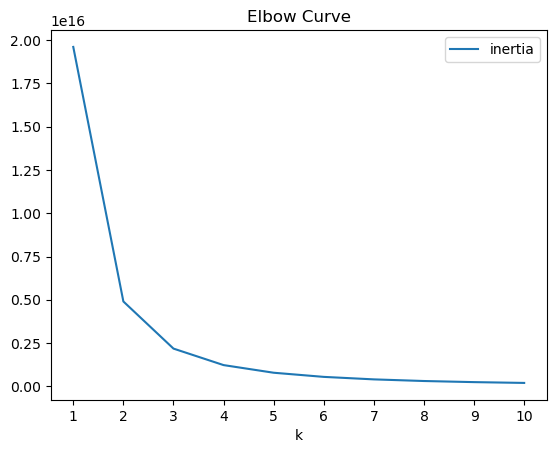

In [74]:
# Plot the Elbow curve
df_elbow.plot.line(x="k",
                   y="inertia",
                   title="Elbow Curve",
                   xticks=k)

### Run KMeans Model with k=3

In [75]:
# Create and initialize the K-Means model and instance for 3 clusters
model = KMeans(n_clusters=3, n_init='auto', random_state=1)

#Print the Model
model

KMeans(n_clusters=3, random_state=42)

In [76]:
# Fit the data to the instance of the model
model.fit(X_train_encoded, y_train)

KMeans(n_clusters=3, random_state=42)

In [77]:
# Make predictions about the data clusters using the trained model
flight_predictions = model.predict(X_test_encoded)

# Print the predictions
print(balanced_accuracy_score(y_test_encoded, y_test_pred))

0.4985390484476468


In [78]:
# Check the model's balanced accuracy on the training set

y_train_pred = model.predict(X_train_encoded)
print(balanced_accuracy_score(y_train_encoded, y_train_pred))

0.2832969759220692


/opt/anaconda3/envs/dev/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2458: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


## Use RandomUnderSampler

In [79]:
# Set up X and y variable
X = encoded_df.copy()
X = X.drop(columns='Delay')


# Set up the y variable
y = encoded_df['Delay']

In [80]:
# Import RandomUnderSampler from imblearn
from imblearn.under_sampling import RandomUnderSampler

# Instantiate the RandomUnderSampler instance
rus = RandomUnderSampler(random_state=1)

# Fit the data to the model
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

# Fit the encoded data to the model
X_encoded_resampled, y_encoded_resampled = rus.fit_resample(X_train_encoded, y_train_encoded)

In [81]:
# Count distinct resampled values
y_resampled.value_counts()

AttributeError: 'numpy.ndarray' object has no attribute 'value_counts'